# Using Linear Algebra to solve predictive tasks and information security tasks for an insurance company #

# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle


## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2451,1,39.0,42900.0,0,0
183,0,18.0,48300.0,2,0
237,0,28.0,48000.0,2,0
36,1,22.0,45300.0,2,0
2088,1,21.0,47900.0,2,0
394,0,27.0,47100.0,0,0
814,0,35.0,47700.0,4,0
1691,0,35.0,30800.0,3,0
1661,1,39.0,35800.0,2,0
355,0,45.0,35700.0,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].round().astype('int64')

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [9]:
df['insurance_benefits'].value_counts()

insurance_benefits
0    4436
1     423
2     115
3      18
4       7
5       1
Name: count, dtype: int64

This Data consistst of 5000 observations. There are no null values to deal with, and the Data Types are now all in a format that Machine learning will be possible. There appears to be a near even split on gender. The age range is from 18 - 65 years, with an average of 31years old. Customers' income ranges from 5,900 to 79,000. The number of family members range from 0 - 6 with an average of 1.2. All these numbers appear to be fine for our project. 

There is an extreme skew in the target data: the vast majority of the clients receive 0 benefits. The range is from 0 - 5, but very few people receive any insurance benefits. Of the 5000 observations, only 564 received an insurance benefit. I'm concerned that we don't have enough non-zero observations to build a successful model. So, perhaps it could be a help to do an upsampling of those observations that had 1-5 insurance benefits. (I'm not sure if this is the purpose of this section though).

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

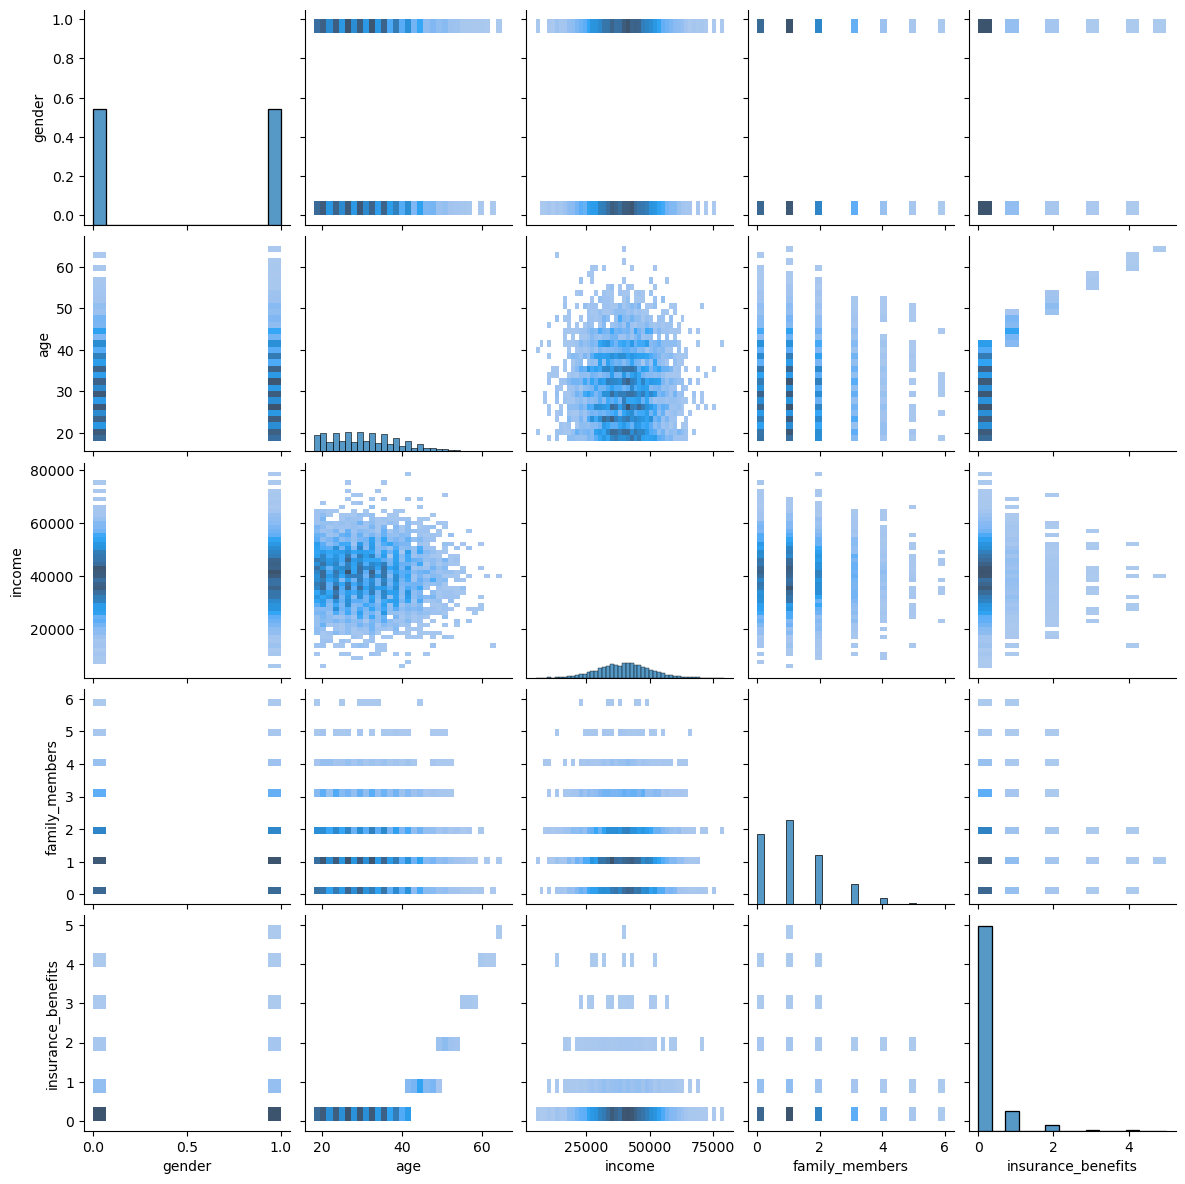

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

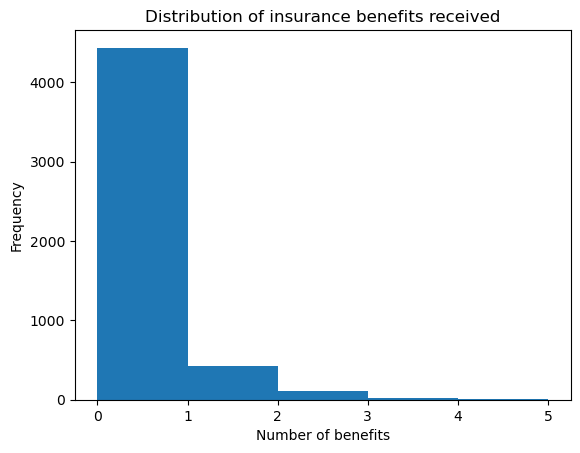

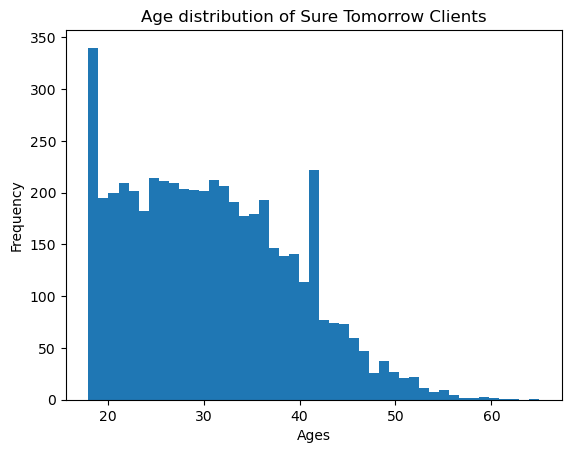

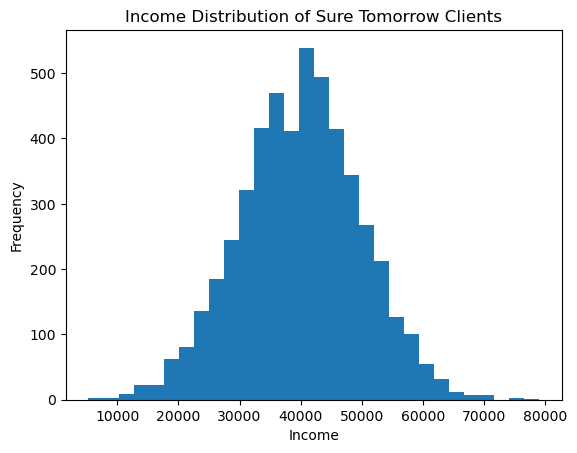

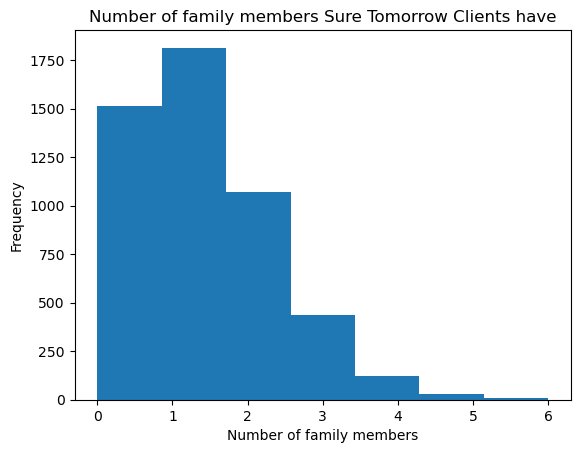

In [11]:
# show the distribution of the benefits received by Sure Tomorrow clients
plt.hist(df['insurance_benefits'], bins=5)
plt.title('Distribution of insurance benefits received')
plt.xlabel('Number of benefits')
plt.ylabel('Frequency')
plt.show()

# show the distribution of the age of Sure Tomorrow clients
plt.hist(df['age'], bins=45)
plt.title('Age distribution of Sure Tomorrow Clients')
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.show()

# Show the distribution of the income ranges
plt.hist(df['income'], bins=30)
plt.title('Income Distribution of Sure Tomorrow Clients')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

# Show the distribution of family members
plt.hist(df['family_members'], bins=7)
plt.title('Number of family members Sure Tomorrow Clients have')
plt.xlabel('Number of family members')
plt.ylabel('Frequency')
plt.show()

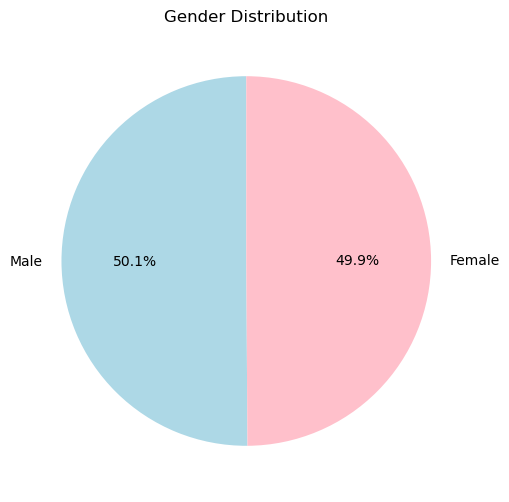

In [12]:
# Assuming gender 0 is male and 1 is female - make a pie chart distribution
gender_counts = df['gender'].value_counts()

# Define labels for the pie chart
labels = ['Male', 'Female']  # Adjust the labels as per your dataset

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'pink'])
plt.title('Gender Distribution')
plt.show()

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

C:\Users\markl\AppData\Local\Temp\ipykernel_10824\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
C:\Users\markl\AppData\Local\Temp\ipykernel_10824\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4544,1,0.476923,0.265823,0.166667,0
1973,1,0.415385,0.589873,0.166667,0
3213,0,0.338462,0.448101,0.166667,0
3778,1,0.276923,0.278481,0.166667,0
2594,0,0.384615,0.753165,0.166667,0


Now, let's get similar records for a given one for every combination

In [17]:
#Euclidian
#Not Scaled
euc_reg = get_knn(df, 0, 5, 'euclidean')
print('Euclidian Not Scaled')
print(euc_reg)
print()

#Scaled
euc_scaled = get_knn(df_scaled, 0, 5, 'euclidean')  # example call
print('Euclidian Scaled')
print(euc_scaled)

Euclidian Not Scaled
      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051
4031       1   44  49600.0               2                   1  3.162278
3424       0   38  49600.0               0                   0  3.316625

Euclidian Scaled
      gender       age    income  family_members  insurance_benefits  distance
0          1  0.630769  0.627848        0.166667                   0  0.000000
2689       1  0.630769  0.634177        0.166667                   0  0.006329
133        1  0.615385  0.636709        0.166667                   0  0.017754
4869       1  0.646154  0.637975        0.166667                   1  0.018418
3275       1  0.646154  0.651899        0.166667                   1  0.028550


c:\Users\markl\Anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\markl\Anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [18]:
#Manhattan
#Not Scaled
man_reg = get_knn(df, 0, 5, 'manhattan')
print('Manhattan Not Scaled')
print(man_reg)
print()

#Scaled
man_scaled = get_knn(df_scaled, 0, 5, 'manhattan') 
print('Manhattan Scaled')
print(man_scaled)

Manhattan Not Scaled
      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
2022       1   41  49600.0               0                   0       1.0
1225       0   42  49600.0               0                   1       3.0
4031       1   44  49600.0               2                   1       4.0
815        1   37  49600.0               2                   0       5.0

Manhattan Scaled
      gender       age    income  family_members  insurance_benefits  distance
0          1  0.630769  0.627848        0.166667                   0  0.000000
2689       1  0.630769  0.634177        0.166667                   0  0.006329
133        1  0.615385  0.636709        0.166667                   0  0.024245
4869       1  0.646154  0.637975        0.166667                   1  0.025511
2103       1  0.630769  0.596203        0.166667                   0  0.031646


c:\Users\markl\Anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\markl\Anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, the data absolutely is different after scaling. Without scaling - the income column is only observations that have a value of $49,600. When scaling was applied the values had more variance.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The Manhattan distance results are extremely similar to the Euclidian distance. Infact, only one observation was different in the closest 5 - the fifth scaled observation. This suggests that regardless of distance metric, we will arrive at highly similar results using this K nearest neighbors algorithm. Manhattan distance measures are less sensitive to outliers and extreme values making it a more appropriate choice in this dataset because there is such ha strong positive skew in both the Benefits Received column and the age column

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [19]:
# calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)
df['insurance_benefits_received'].value_counts(normalize=True)
display(df.head())

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0


As stated above, there is a significant class imbalance here. Since this is a KNN task there will not be a need to rebalance the classes.

In [20]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [21]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [22]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df)) 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [23]:
#split the data into training and test sets
X = df[['age', 'gender', 'income', 'family_members']]
y = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)


# Scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Loop over k values
for k in range(1, 11):
    # Unscaled data
    knn_unscaled = KNeighborsClassifier(n_neighbors=k)
    knn_unscaled.fit(X_train, y_train)
    y_predict_unscaled = knn_unscaled.predict(X_test)
    f1_unscaled = f1_score(y_test, y_predict_unscaled, average='binary')
    
    # Scaled data
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(X_train_scaled, y_train)
    y_predict_scaled = knn_scaled.predict(X_test_scaled)
    f1_scaled = f1_score(y_test, y_predict_scaled, average='binary')
    
    # Print results
    print(f"k={k}: Unscaled F1={f1_unscaled:.2f}, Scaled F1={f1_scaled:.2f}")


k=1: Unscaled F1=0.60, Scaled F1=0.96
k=2: Unscaled F1=0.41, Scaled F1=0.93
k=3: Unscaled F1=0.41, Scaled F1=0.94
k=4: Unscaled F1=0.28, Scaled F1=0.90
k=5: Unscaled F1=0.27, Scaled F1=0.92
k=6: Unscaled F1=0.11, Scaled F1=0.91
k=7: Unscaled F1=0.11, Scaled F1=0.93
k=8: Unscaled F1=0.07, Scaled F1=0.91
k=9: Unscaled F1=0.08, Scaled F1=0.92
k=10: Unscaled F1=0.00, Scaled F1=0.89


In [25]:
for P in [0,df['insurance_benefits_received'].mean(), .5, 1]:
    y_pred_rnd = rnd_model_predict(P, size=len(y_test))
    f1_dummy = f1_score(y_test, y_pred_rnd)
    print(f'Dummy model with P={P:.2f}: F1={f1_dummy:.2f}')

Dummy model with P=0.00: F1=0.00
Dummy model with P=0.11: F1=0.11
Dummy model with P=0.50: F1=0.16
Dummy model with P=1.00: F1=0.20


## Task 2 Conclusion ##
The Scaled data was able to outperform the unscaled data with values quite close to 1. Without scaling we can see that the f1 score decreases to 0 by adding more k values. The f1 score decreases with the scaled data, but it remains very high. This shows the importance of scaling the data to make the best predictions on whether or not a given client will receive an insurance benefit.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [26]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones((len(X), 1)), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [27]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [28]:
#split the data into training and test sets
X = df[['age', 'gender', 'income', 'family_members']]
y = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)


# Scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-6.50583302e-01  2.47409374e-02 -7.31018901e-04  1.36927859e-07
 -6.32915410e-03]
RMSE: 0.23
R2: 0.66


In [29]:
# using the LR function on the scaled data
lr_scaled = MyLinearRegression()

lr_scaled.fit(X_train_scaled, y_train)
print(lr_scaled.weights)

y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

[ 0.11457143  0.20964508 -0.00036542  0.00135641 -0.00688148]
RMSE: 0.23
R2: 0.66


The RMSE and R2 scores are the same using both the regular and the scaled data. RMSE = .23, and R2 = .66. The only difference appears in the weights printout. The second and fifth attributes are of a different weight.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [30]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [31]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [32]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [33]:
if np.linalg.det(P) != 0:
    print("Matrix P is invertible.")
else:
    print("Matrix P is not invertible.")

Matrix P is invertible.


Can you guess the customers' ages or income after the transformation?

In [34]:
X_transformed = X @ P
display(X_transformed)

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

$X' = XP$ Original equation

$P^{-1} X' = P^{-1} (XP)$ Multiply both sides by the inverse of P

$P^{-1} (XP) = (P^{-1} P)X = IX = X$ Working just with the right side of the equation we can see the Identity Matrix

$X = P^{-1} X'$ Simplified equation

As long as P is invertible, X can be recovered


In [35]:
X_recovered = X_transformed @ np.linalg.inv(P)
display(X_recovered)

array([[1.00000000e+00, 4.10000000e+01, 4.96000000e+04, 1.00000000e+00],
       [6.66555413e-13, 4.60000000e+01, 3.80000000e+04, 1.00000000e+00],
       [3.84747671e-13, 2.90000000e+01, 2.10000000e+04, 1.41940791e-12],
       ...,
       [1.18077361e-12, 2.00000000e+01, 3.39000000e+04, 2.00000000e+00],
       [1.00000000e+00, 2.20000000e+01, 3.27000000e+04, 3.00000000e+00],
       [1.00000000e+00, 2.80000000e+01, 4.06000000e+04, 1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [36]:
print("Original Matrix (X):")
print(np.array(X))
print("\nTransformed Matrix (X_transformed):")
print(X_transformed)
print("\nRecovered Matrix (X_recovered):")
print(X_recovered)

Original Matrix (X):
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Transformed Matrix (X_transformed):
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

Recovered Matrix (X_recovered):
[[1.00000000e+00 4.10000000e+01 4.96000000e+04 1.00000000e+00]
 [6.66555413e-13 4.60000000e+01 3.80000000e+04 1.00000000e+00]
 [3.84747671e-13 2.90000000e+01 2.10000000e+04 1.41940791e-12]
 ...
 [1.18077361e-12 2.00000000e+01 3.39000000e+04 2.00000000e+00]
 [1.00000000e+00 2.20000000e

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Because python uses a floating point numerical system, some of the numbers lose precision when arithmetical operations are performed. This is a result of very small rounding errors that show up in the transformation and recovery process. It is also possible that calculating $P^{-1}$ is an aproximation process as well that could result in small variation between the original and recovered data.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

1. How $w$ and $w{p}$ are linked by simplifying the formula for $w{p}$?

$w_{p} = [(XP)^T XP]^{-1} (XP)^T y$ : Original formula

$w_{p} = [(P^T X^T) XP]^{-1} P^T X^T y$ : Transpose

$w_{p} = [(XP)^{-1} (P^T X^T)^{-1} P^T X^T y$ : Distribute inverses

$w_{p} = [P^{-1} X^{-1} X^T{-1} P^T{-1}] P^T X^T y$ : Distribute inverses again

$w_{p} = P^{-1}[X^{-1} (X^T)^{-1}](P^T{-1}) P^T X^T y$ : Associative Property - notice that $(P^T{-1}) P^T$ is the same as an Identity Matrix

$w_{p} = P^{-1}[X^{-1} (X^T)^{-1}]IX^T y$ : Fill in I for the identity matrix

$w_{p} = p^{-1}[X^{-1} (X^T)^{-1}]X^T y$ : Remove the Identity Matrix

$w_{p} = p^{-1}[X^T X]^{-1} X^T y$ : Undo the distribution of the inverse. Notice that $[X^T X]^{-1} X^T y$ is $w$

$w_{p} = P^{-1} w$ : Replace $[X^T X]^{-1} X^T y$ with $w$

2. What would be predicted values with $w_{p}$?

Linear Regression predictive models use the formula $a = Xw$

So if we're using the obfuscated data then it would be $a' = XPw_{p}$

Then we need to replace $w_{p}$ with our previously written $P^{-1}w$. This gives us $a' = XPP^{-1}w$

After that we can put in an Identity matrix in place of $PP^{-1}$. It will look like: $a' = XIw$

Then we remove the Identity matrix and are left with $a' = Xw$.

And since $a = Xw$ we can place that into our formula and see that $a' = a$

**Analytical proof**

3. What does that mean for the quality of linear regression if you measure it with RMSE?

Since we were able to show that $a' = a$ in the linear regression algrebra, it proves that there will be no diference in the RMSE values. This means that if we use obfuscated data or the original we should get the same results in our RMSE scores.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Multiply X and P to get an obfuscated dataframe
- Use $XP$ as the new feature matrix

In [37]:
#Create a square matrix P of random numbers
def make_square_matrix(size):
    rand_num = np.random.default_rng(seed=8420)
    P = rand_num.random(size=(size, size))
    while np.linalg.det(P) == 0:
        P = rand_num.random(size=(size, size))
    return P

P = make_square_matrix(X.shape[1])

In [38]:
# Check if the matrix is invertible
if np.linalg.det(P) != 0:
    print("Matrix P is invertible.")
else:
    print("Matrix P is not invertible.")

Matrix P is invertible.


In [39]:
#multipy the X matrix by P
X_obfuscated = X @ P
columns = ['age', 'gender', 'income', 'family_members']
X_obfuscated = pd.DataFrame(X_obfuscated, columns=columns)
display(X_obfuscated)

,age,gender,income,family_members
0,34218.140337,25921.349871,22899.819712,11166.714975
1,26217.446858,19872.966913,17550.970703,8559.002423
2,14488.921741,10985.814160,9700.968100,4730.368810
3,28766.495371,21779.810799,19245.135890,9385.764771
4,18006.683733,13646.249480,12053.665390,5877.198053
...,...,...,...,...
4995,24628.846967,18655.641304,16481.121622,8038.092798
4996,36148.444731,27375.569223,24187.020033,11794.627891
4997,23386.202193,17708.720711,15646.835595,7631.239417
4998,22559.115601,17084.688300,15095.225632,7362.837707


In [40]:
# Run the linear regression on the original data
#split the data into training and test sets
X = df[['age', 'gender', 'income', 'family_members']]
y = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr_X = MyLinearRegression()
lr_X.fit(X_train, y_train)

print(lr_X.weights)

y_test_pred = lr_X.predict(X_test)
eval_regressor(y_test, y_test_pred)


[-6.50583302e-01  2.47409374e-02 -7.31018901e-04  1.36927859e-07
 -6.32915410e-03]
RMSE: 0.23
R2: 0.66


In [41]:
#Run the same linear regression using the obfuscated data
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_obfuscated, y, test_size=.3, random_state=12345)

lr_X_t = MyLinearRegression()
lr_X_t.fit(X_train_t, y_train_t)

print(lr_X_t.weights)

y_test_pred_t = lr_X_t.predict(X_test_t)
eval_regressor(y_test_t, y_test_pred_t)

[-0.65058334 -0.02011059  0.03174069 -0.00425424 -0.0032399 ]
RMSE: 0.23
R2: 0.66


### Obfuscated Data Linear Regression Conclusion ###

As demonstrated above, there is no difference in the outcomes of using obfuscated data with the Linear Regression ML model. The RMSE and R2 scores were the same using both datasets. As a result we can confidently protect client privacy while also using Machine Learning to predict client behavior and benefits.

# Conclusions

The Sure Tomorrow Insurance Company was looking to use Machine Learning in order to find customers who are simlar to one another so that they can do better targeted marketing. Then they wanted to be able to predict which new customers are most likely to receive an insurance benefit. After that, they wanted to predict the number of insurance benefits a new customer would receive based on a linear regression model. Finally because they're an insurance company they need to keep their customer data private, so they've asked that we develop a data transformation algorithm to protect the private information of their customers.

For the first task we used a K Nearest Neighbors algorithm to find the customers most similar to any given customer. Then we used both scaled and unscaled data and measured the distance using both Euclidean and Manhattan distance metrics. Scaling the data did produce significantly different results than the unscaled data. It did not make a big difference on which distance metric was used. 

In the second task we then wanted to find which customers were most likely to receive a benefit, and test that against a "dummy model" to make sure that we were predicting better than random chance. Again, we wanted to see whether we could produce better results than random chance. I used the KNN Classifier built by scikit.learn and was able to produce significantly better results than the random model. This was especially shown in the scaled data which outperformed the original data. It is important, therefore, to scale the data when running a KNN classifier in order to have a higher performing model. 

In the third task we used a linear regression model to check and see if using scaled data affected the prediction results. There is no noticable difference in the RMSE or r2_score. The difference is in the magnitude of the results from the regression. 

In the forth and fifth tasks we worked on obfuscating the data so that private information is not accidentally getting leaked. In order to accomplish this task we created an random invertible matrix to multiply by the original data. This allowed caused the information in the product to be unrecognizable as meaningful data, but the calculations for the Linear Regression stayed true. We proved that we could recover the original data by multiplying the new matrix by the inverted matrix and received the original information again. We then showed that whether we use the original data or the obfuscated data the Linear Regression model produced the same r2_score and RMSE.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells are arranged in order of logic and execution
- [ ]  Task 1 has been performed
    - [ ]  There is the procedure that can return k similar customers for a given one
    - [ ]  The procedure is tested for all four proposed combinations
    - [ ]  The questions re the scaling/distances are answered
- [ ]  Task 2 has been performed
    - [ ]  The random classification model is built and tested for all for probability levels
    - [ ]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [ ]  Task 3 has been performed
    - [ ]  The linear tegression solution is implemented with matrix operations.
    - [ ]  RMSE is calculated for the implemented solution.
- [ ]  Task 4 has been performed
    - [ ]  The data is obfuscated with a random and invertible matrix P
    - [ ]  The obfuscated data is recoved, few examples are printed out
    - [ ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [ ]  The computational proof that the transformation does not affect RMSE is provided
- [ ]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>